# MNIST 手寫數字辨識資料集介紹 & 多層感知器模型(MLP)
    使用tensorflow編寫MLP模型,進行MNIST資料集分類模型建立

### STEP1. 匯入 Tensorflow 及相關模組
    首先匯入 Tensorflow 及相關模組:

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib.pylab import rcParams

np.random.seed(10)

import warnings
warnings.filterwarnings('ignore')

### STEP2. 下載 mnist 資料
    下載MNIST資料,我們將建立以下Tensorflow 程式, 下載並讀取 mnist 資料.
    Mnist 資料的下載路徑在

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True) 

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


### STEP3. 讀取與查看 mnist 資料

In [3]:
#讀取
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True) 
x_train_image = mnist.train.images
y_train_label = mnist.train.labels
x_test_image = mnist.test.images
y_test_label = mnist.test.labels

#查看
print("\t[Info] train data={:7,}".format(len(x_train_image)))  
print("\t[Info] test  data={:7,}".format(len(x_test_image))) 


Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
	[Info] train data= 55,000
	[Info] test  data= 10,000


由上可以知道 training data 共有 55,000 筆; testing data 共有 10,000 筆。

## 查看訓練資料
接著我們來看載入資料的長相與格式.

### STEP1. 訓練資料是由 images 與 labels 所組成

In [4]:
print("\t[Info] Shape of train data=%s" % (str(x_train_image.shape)))
print("\t[Info] Shape of train label=%s" % (str(y_train_label.shape)))

	[Info] Shape of train data=(55000, 784)
	[Info] Shape of train label=(55000, 10)


訓練資料是由 images 與 labels 所組成共有 55000 筆,
##### 每一筆image 代表某個數字的影像為 28x28 pixels=784個pixels組成，可視為一個大型矩陣(array)，矩陣的每一項資料代表每個pixel顏色深淺的數值。
##### 每一個label都是一個 one-hot vector。

In [5]:
print(x_train_image[0])
print(y_train_label[0])

[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.

image資料已標準化，介於0~1之間；label資料已one-hot encoding，所以資料不必再轉換

### STEP2. 定應 plot_image 函數顯示數字影像

In [6]:
import matplotlib.pyplot as plt
def plot_image(image):
    fig = plt.gcf()
    fig.set_size_inches(2, 2)
    plt.imshow(image.reshape(28,28), cmap='binary') # cmap='binary' 參數設定以黑白灰階顯示
    plt.show()

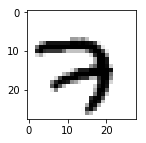

In [7]:
plot_image(x_train_image[0])

In [8]:
#argmax()返回的是沿軸axis最大值的索引值
from numpy import argmax
argmax(y_train_label[0])

7

### 查看多筆訓練資料 images 與 labels
接下來我們將建立 plot_images_labels_predict 函數, 可以顯示多筆資料的影像與 label.

### STEP1. 建立 plot_images_labels_predict() 函數
因為後續我們希望能很方便查看數字圖形, 真實的數字與預測結果, 所以我們建立了以下函數:

In [9]:
def plot_images_labels_predict(images, labels, prediction, idx, num=10):  
    fig = plt.gcf()  
    fig.set_size_inches(12, 14)  
    if num > 25: num = 25  
    for i in range(0, num):  
        ax=plt.subplot(5,5, 1+i)  
        ax.imshow(images[idx].reshape(28,28), cmap='binary')  
        title = "l=" + str(argmax(labels[idx]))  
        if len(prediction) > 0:  
            title = "l={},p={}".format(str(labels[idx]), str(prediction[idx]))  
        
        ax.set_title(title, fontsize=10)  
        ax.set_xticks([]); ax.set_yticks([])  
        idx+=1  
    plt.show()

### STEP2. 查看訓練資料的前 10 筆資料

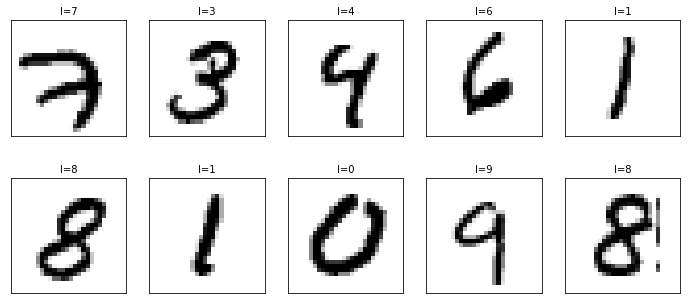

In [10]:
plot_images_labels_predict(x_train_image, y_train_label, [], 0, 10)

### 多層感知器模型資料前處理
tensorflow的 MNIST的資料已處理好(image資料 normalization，label 資料One-hot-encoding)。

### 建立模型
我們將建立以下多層感知器 Multilayer Perceptron 模型, 輸入層 (x) 共有 28x28=784 個神經元, Hidden layers (h) 共有 256 層; 輸出層 (y) 共有 10 個 神經元:

## create graph

In [11]:
tf.reset_default_graph() #重新 build graph   

#### Step 1 : define placeholder 
    placeholder:盛接data進入graph

In [12]:
input_data = tf.placeholder(dtype = tf.float32,
                            shape = [None,x_train_image.shape[1]],#784
                            name  = 'input_data')
y_true     = tf.placeholder(dtype = tf.float32,
                            shape = [None,y_train_label.shape[1]],#10
                            name  = 'y_true')

#### Step 2 : creat variables and operations
    定義模型架構:
        決定hidden layers 層數與其中的neurons 數量
        決定該層使用的 activation function

In [13]:
x1 = tf.layers.dense(input_data, 256, activation=tf.nn.relu, name= 'hidden1')
out = tf.layers.dense(x1, y_train_label.shape[1], name= 'output')

y_pred = out

#### Step 3 : define loss function and calculate loss
    選擇 Loss Function 
        常用於 regression:Mean Squared Error, Mean Absolate Error,...
        常用於 classification:Binary Crossentropy(logloss), Categoryical Crossentropy
#### tf.nn.softmax_cross_entropy_with_logits 為 Categoryical Crossentropy , 它同時會將輸出取softmax,因此不需要在最後一層 dence layer 加 softmax 的 activation function

In [14]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



#### Step 4 : define optimizer and define variables update operations
定義 optimizer 和定義更新 variables的方式

    選擇optimizer(tf.train)
        SGD :Stochastic Gradient Descent 隨機梯度下降
        Adagrad : Adaptive Learning Rate
        RMSprop : Similar with Adagrad
        Adam : Similar with RMSprop + Momentum
    主要參數 : learning rate (experiment later) 學習率        

In [15]:
lr = 0.001
opt = tf.train.AdamOptimizer(learning_rate=lr)
update = opt.minimize(loss)

#### check global variables (optional)

In [16]:
tf.global_variables() 

[<tf.Variable 'hidden1/kernel:0' shape=(784, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(256, 10) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'hidden1/kernel/Adam:0' shape=(784, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/kernel/Adam_1:0' shape=(784, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias/Adam:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias/Adam_1:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'output/kernel/Adam:0' shape=(256, 10) dtype=float32_ref>,
 <tf.Variable 'output/kernel/Adam_1:0' shape=(256, 10) dtype=float32_ref>,
 <tf.Variable 'output/bias/Adam:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'output/bias/Adam_1:0' shape=(10,) dtype=float32_ref>]

### run session
#### step 1 : run global variables initialization
    建立session (tf.session())
    執行參數初始化(tf.global_variables_initializer())
    initialize 的方式可以在layer設定(kernel_initializer/bais_initializer),e.g.tf.zero_initializer,...

In [17]:
init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)

#### step 2 : run optimizer
    訓練參數
    epoch : 更新多少遍
    bs(batch size) : 每次更新要用到多少筆資料
    update_per_epoch : 每個epoch要更新多少次
#### mnist.train.next_batch() 從數據集中隨機取出幾張照片
    相關連結: https://blog.csdn.net/u013608336/article/details/78747102

In [18]:
from tqdm import tqdm_notebook #進度條
from sklearn.metrics import accuracy_score

#訓練參數
epoch = 30 #更新30次
bs = 32 #每次32筆
update_per_epoch = 100 #1個epoch更新100次

tr_loss = list() #紀錄training Loss
tr_acc = list() #紀錄 training Accuracy
ts_loss = list() #紀錄testing Loss
ts_acc = list() #紀錄testing Accuracy

#### sess.run
    sess.run(update) 為更新參數指令
    sess.run(loss) 為取出當下loss

In [19]:
x_batch, y_batch = mnist.train.next_batch(bs)
print (x_batch.shape)
print (y_batch.shape)

(32, 784)
(32, 10)


In [20]:
for i in range(epoch):
    
    #calculate training loss & update variables
    training_loss = 0
    training_acc = 0
    bar = tqdm_notebook(range(update_per_epoch))
    for j in bar: 
        
        x_batch, y_batch = mnist.train.next_batch(bs) #從數據集中隨機取出32張照片
        
        #"_"python:一個臨時性名稱使用；分配一個名稱，但在後面不會用到
        tr_pred, train_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={input_data:x_batch,y_true:y_batch})
        
        training_loss += train_loss_batch 
        
        #training Accuracy
        training_acc_batch = accuracy_score(np.argmax(y_batch,axis= 1),np.argmax(tr_pred,axis= 1))
        training_acc += training_acc_batch        
        
        if j % 5 == 0:
            bar.set_description('loss: %.4g' % train_loss_batch)

    
    
    #算平均
    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    tr_loss.append(training_loss)
    tr_acc.append(training_acc)
    
    print('epoch {epochs}: training loss{training_loss}'.format(epochs = (i+1),training_loss= training_acc))
    
    
    

A Jupyter Widget


epoch 1: training loss0.805625


A Jupyter Widget


epoch 2: training loss0.8990625


A Jupyter Widget


epoch 3: training loss0.901875


A Jupyter Widget


epoch 4: training loss0.91875


A Jupyter Widget


epoch 5: training loss0.924375


A Jupyter Widget


epoch 6: training loss0.9359375


A Jupyter Widget


epoch 7: training loss0.93875


A Jupyter Widget


epoch 8: training loss0.945


A Jupyter Widget


epoch 9: training loss0.9421875


A Jupyter Widget


epoch 10: training loss0.9459375


A Jupyter Widget


epoch 11: training loss0.945625


A Jupyter Widget


epoch 12: training loss0.9503125


A Jupyter Widget


epoch 13: training loss0.95


A Jupyter Widget


epoch 14: training loss0.9575


A Jupyter Widget


epoch 15: training loss0.956875


A Jupyter Widget


epoch 16: training loss0.9571875


A Jupyter Widget


epoch 17: training loss0.9603125


A Jupyter Widget


epoch 18: training loss0.9696875


A Jupyter Widget


epoch 19: training loss0.9728125


A Jupyter Widget


epoch 20: training loss0.9671875


A Jupyter Widget


epoch 21: training loss0.9625


A Jupyter Widget


epoch 22: training loss0.9703125


A Jupyter Widget


epoch 23: training loss0.965625


A Jupyter Widget


epoch 24: training loss0.9684375


A Jupyter Widget


epoch 25: training loss0.96875


A Jupyter Widget


epoch 26: training loss0.9715625


A Jupyter Widget


epoch 27: training loss0.961875


A Jupyter Widget


epoch 28: training loss0.97375


A Jupyter Widget


epoch 29: training loss0.9740625


A Jupyter Widget


epoch 30: training loss0.9728125


### polt model training result

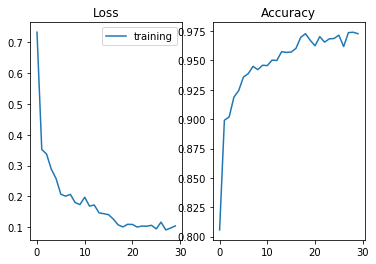

In [21]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)),tr_loss,label = 'training')
plt.title('Loss')
plt.legend(loc = 'best')
plt.subplot(122)
plt.plot(range(len(tr_acc)),tr_acc,label = 'training')
plt.title('Accuracy')
plt.show()

### Save model

In [22]:
saver = tf.train.Saver()
saver.save(sess, "saved_models/model.ckpt")

'saved_models/model.ckpt'

### load model

In [23]:
sess = tf.Session()
saver.restore(sess, "saved_models/model.ckpt")
saver = tf.train.Saver()

INFO:tensorflow:Restoring parameters from saved_models/model.ckpt


In [24]:
print('epoch {epochs}: training loss{training_loss}'.format(epochs = (i+1),training_loss= training_loss))

epoch 30: training loss0.10401486099697649


### 以測試資料評估模型準確率與預測
    模型已建立完畢，接下來使用test測試資料來評估模型置準確率

#### Step1. 模型準確率

In [25]:
print('epoch {epochs}: training acc{training_acc}'.format(epochs = (i+1),training_acc= training_acc))

epoch 30: training acc0.9728125


#### Step2. 進行預測
    將test資料帶入模型進行預測。

In [26]:
print("\t[Info] Making prediction to x_Test_norm") 
i = 1
i = tqdm_notebook(range(i))

for j in i:
    #test資料帶入
    ts_pred,testing_loss = sess.run([y_pred, loss], feed_dict={input_data:x_test_image,y_true:y_test_label})
    
    #testing Accuracy
    testing_acc = accuracy_score(np.argmax(y_test_label,axis= 1),np.argmax(ts_pred,axis= 1))
    i.set_description('loss: %.4g' % testing_acc)


	[Info] Making prediction to x_Test_norm


A Jupyter Widget

In [27]:
print("\t[Info] Show 10 prediction result (From 0~10):") 

list = []
for i in range(10):
    list.append(np.argmax(ts_pred[i]))
print(list)

	[Info] Show 10 prediction result (From 0~10):
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


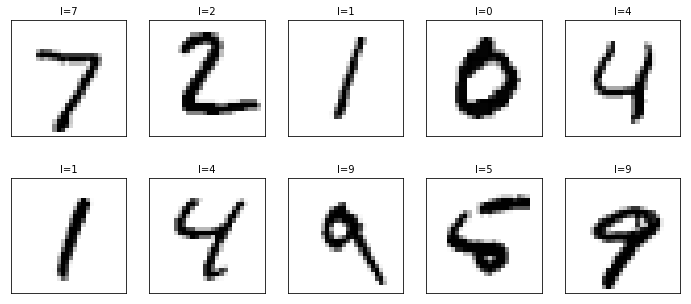

In [28]:
plot_images_labels_predict(x_test_image, ts_pred, [], 0, 10)

## Conclusion
    再使用Tensorflow重新寫一次Mnist手寫資料集可以發現，Keras與Tensorflow的使用方式相差許多。
    通過這次的訓練，以新手來說，對於Tensorflow會更加了解。